<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:21] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


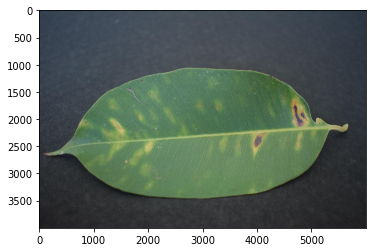

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

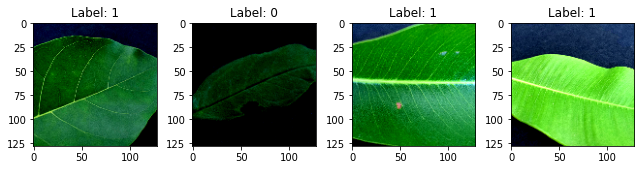

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:27] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:29] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2774343521636422 samples/sec                   batch loss = 0.7061890959739685 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2893394282021944 samples/sec                   batch loss = 0.5248850584030151 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2388908506684992 samples/sec                   batch loss = 1.2813106775283813 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2810391241430579 samples/sec                   batch loss = 0.5440940856933594 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.304613694449363 samples/sec                   batch loss = 0.9108280539512634 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.292450405733454 samples/sec                   batch loss = 0.7793986797332764 | accuracy = 0.6666666666666666


Epoch[1] Batch[35] Speed: 1.297343275920878 samples/sec                   batch loss = 0.7069914937019348 | accuracy = 0.6785714285714286


Epoch[1] Batch[40] Speed: 1.2996517393395575 samples/sec                   batch loss = 0.45128345489501953 | accuracy = 0.68125


Epoch[1] Batch[45] Speed: 1.2942309916079338 samples/sec                   batch loss = 0.26841115951538086 | accuracy = 0.6888888888888889


Epoch[1] Batch[50] Speed: 1.2972005354816931 samples/sec                   batch loss = 1.399289608001709 | accuracy = 0.68


Epoch[1] Batch[55] Speed: 1.297617610309032 samples/sec                   batch loss = 1.3472402095794678 | accuracy = 0.6772727272727272


Epoch[1] Batch[60] Speed: 1.299934101465148 samples/sec                   batch loss = 0.31189435720443726 | accuracy = 0.6791666666666667


Epoch[1] Batch[65] Speed: 1.2983658461046508 samples/sec                   batch loss = 0.728844940662384 | accuracy = 0.6807692307692308


Epoch[1] Batch[70] Speed: 1.3063598199820878 samples/sec                   batch loss = 1.4085736274719238 | accuracy = 0.6642857142857143


Epoch[1] Batch[75] Speed: 1.296447931405133 samples/sec                   batch loss = 0.9333594441413879 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.2983527839971818 samples/sec                   batch loss = 0.9416067004203796 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.2930473760077406 samples/sec                   batch loss = 0.6427817940711975 | accuracy = 0.6529411764705882


Epoch[1] Batch[90] Speed: 1.2896852338361326 samples/sec                   batch loss = 0.31872397661209106 | accuracy = 0.6583333333333333


Epoch[1] Batch[95] Speed: 1.299134058578987 samples/sec                   batch loss = 0.5173622369766235 | accuracy = 0.6605263157894737


Epoch[1] Batch[100] Speed: 1.299388117439567 samples/sec                   batch loss = 0.744393527507782 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.3067707957272565 samples/sec                   batch loss = 0.30550429224967957 | accuracy = 0.6619047619047619


Epoch[1] Batch[110] Speed: 1.2952509594592518 samples/sec                   batch loss = 0.33720746636390686 | accuracy = 0.6659090909090909


Epoch[1] Batch[115] Speed: 1.3010678048685538 samples/sec                   batch loss = 1.1363282203674316 | accuracy = 0.6673913043478261


Epoch[1] Batch[120] Speed: 1.2969261768852496 samples/sec                   batch loss = 0.30012133717536926 | accuracy = 0.6666666666666666


Epoch[1] Batch[125] Speed: 1.2960434220327943 samples/sec                   batch loss = 0.5843977928161621 | accuracy = 0.662


Epoch[1] Batch[130] Speed: 1.2991338573836229 samples/sec                   batch loss = 0.571692943572998 | accuracy = 0.6615384615384615


Epoch[1] Batch[135] Speed: 1.2949776247388871 samples/sec                   batch loss = 0.7308368682861328 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2944701521108226 samples/sec                   batch loss = 0.8313607573509216 | accuracy = 0.6571428571428571


Epoch[1] Batch[145] Speed: 1.2925918038854454 samples/sec                   batch loss = 0.4895574450492859 | accuracy = 0.6551724137931034


Epoch[1] Batch[150] Speed: 1.2867673288175492 samples/sec                   batch loss = 0.34908613562583923 | accuracy = 0.655


Epoch[1] Batch[155] Speed: 1.2892817624194075 samples/sec                   batch loss = 0.5960108041763306 | accuracy = 0.6548387096774193


Epoch[1] Batch[160] Speed: 1.288502591410544 samples/sec                   batch loss = 0.1456204354763031 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.2882969895996141 samples/sec                   batch loss = 0.2852579355239868 | accuracy = 0.656060606060606


Epoch[1] Batch[170] Speed: 1.2953754679722018 samples/sec                   batch loss = 1.3664534091949463 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.2928844569038154 samples/sec                   batch loss = 1.3067405223846436 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.289802130125729 samples/sec                   batch loss = 0.35042545199394226 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.2881693872179494 samples/sec                   batch loss = 0.7947365641593933 | accuracy = 0.6648648648648648


Epoch[1] Batch[190] Speed: 1.2879047670516794 samples/sec                   batch loss = 0.5216451287269592 | accuracy = 0.6697368421052632


Epoch[1] Batch[195] Speed: 1.2908955754560183 samples/sec                   batch loss = 0.278695672750473 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.290534229831672 samples/sec                   batch loss = 1.12473726272583 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.287134467570337 samples/sec                   batch loss = 0.4479960799217224 | accuracy = 0.6695121951219513


Epoch[1] Batch[210] Speed: 1.2908311161925397 samples/sec                   batch loss = 0.6700434684753418 | accuracy = 0.6702380952380952


Epoch[1] Batch[215] Speed: 1.2929681533335522 samples/sec                   batch loss = 0.8626279234886169 | accuracy = 0.6674418604651163


Epoch[1] Batch[220] Speed: 1.287176733066751 samples/sec                   batch loss = 0.747221052646637 | accuracy = 0.6681818181818182


Epoch[1] Batch[225] Speed: 1.3022268358817903 samples/sec                   batch loss = 0.5445215106010437 | accuracy = 0.6733333333333333


Epoch[1] Batch[230] Speed: 1.2961389431933494 samples/sec                   batch loss = 0.7238236665725708 | accuracy = 0.6739130434782609


Epoch[1] Batch[235] Speed: 1.2993770474586768 samples/sec                   batch loss = 0.5520718097686768 | accuracy = 0.6734042553191489


Epoch[1] Batch[240] Speed: 1.3009886052328583 samples/sec                   batch loss = 0.6377840638160706 | accuracy = 0.6729166666666667


Epoch[1] Batch[245] Speed: 1.299897036959385 samples/sec                   batch loss = 0.665306568145752 | accuracy = 0.6724489795918367


Epoch[1] Batch[250] Speed: 1.2993013740959334 samples/sec                   batch loss = 0.9495767951011658 | accuracy = 0.672


Epoch[1] Batch[255] Speed: 1.2999124466738259 samples/sec                   batch loss = 0.6766358017921448 | accuracy = 0.6705882352941176


Epoch[1] Batch[260] Speed: 1.298520199828827 samples/sec                   batch loss = 0.4061127007007599 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.2874656545312997 samples/sec                   batch loss = 0.5261653661727905 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.288084827474326 samples/sec                   batch loss = 0.6279122829437256 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.3003965782578382 samples/sec                   batch loss = 0.5130062103271484 | accuracy = 0.6745454545454546


Epoch[1] Batch[280] Speed: 1.302273029820248 samples/sec                   batch loss = 0.49272146821022034 | accuracy = 0.6767857142857143


Epoch[1] Batch[285] Speed: 1.301219673176792 samples/sec                   batch loss = 0.38078543543815613 | accuracy = 0.6789473684210526


Epoch[1] Batch[290] Speed: 1.300213462588868 samples/sec                   batch loss = 0.29778650403022766 | accuracy = 0.6793103448275862


Epoch[1] Batch[295] Speed: 1.2984519621138932 samples/sec                   batch loss = 0.6447477340698242 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.3033035916400098 samples/sec                   batch loss = 0.7029036283493042 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.3042579115241446 samples/sec                   batch loss = 0.8941298127174377 | accuracy = 0.6770491803278689


Epoch[1] Batch[310] Speed: 1.2994866485797887 samples/sec                   batch loss = 0.8953213691711426 | accuracy = 0.6774193548387096


Epoch[1] Batch[315] Speed: 1.3029747313760771 samples/sec                   batch loss = 0.5115878582000732 | accuracy = 0.6785714285714286


Epoch[1] Batch[320] Speed: 1.2921951707936996 samples/sec                   batch loss = 0.566119909286499 | accuracy = 0.678125


Epoch[1] Batch[325] Speed: 1.29203296385943 samples/sec                   batch loss = 0.2695978581905365 | accuracy = 0.6792307692307692


Epoch[1] Batch[330] Speed: 1.296093884287816 samples/sec                   batch loss = 0.7676677107810974 | accuracy = 0.6772727272727272


Epoch[1] Batch[335] Speed: 1.2954985999266586 samples/sec                   batch loss = 0.6090327501296997 | accuracy = 0.6753731343283582


Epoch[1] Batch[340] Speed: 1.290214063421391 samples/sec                   batch loss = 0.41511160135269165 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2918852218226227 samples/sec                   batch loss = 1.2281246185302734 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.2921897964147566 samples/sec                   batch loss = 0.3827740550041199 | accuracy = 0.6764285714285714


Epoch[1] Batch[355] Speed: 1.294253156422717 samples/sec                   batch loss = 0.207846000790596 | accuracy = 0.6774647887323944


Epoch[1] Batch[360] Speed: 1.288385831609057 samples/sec                   batch loss = 1.225503921508789 | accuracy = 0.6756944444444445


Epoch[1] Batch[365] Speed: 1.288881216801288 samples/sec                   batch loss = 0.3490831255912781 | accuracy = 0.6760273972602739


Epoch[1] Batch[370] Speed: 1.2879311648537575 samples/sec                   batch loss = 0.8233022093772888 | accuracy = 0.6763513513513514


Epoch[1] Batch[375] Speed: 1.2907142319164433 samples/sec                   batch loss = 0.689288854598999 | accuracy = 0.678


Epoch[1] Batch[380] Speed: 1.285862962971195 samples/sec                   batch loss = 0.6938668489456177 | accuracy = 0.6789473684210526


Epoch[1] Batch[385] Speed: 1.2854320369793892 samples/sec                   batch loss = 0.3510691225528717 | accuracy = 0.6805194805194805


Epoch[1] Batch[390] Speed: 1.2839226289119552 samples/sec                   batch loss = 0.9067959189414978 | accuracy = 0.6807692307692308


Epoch[1] Batch[395] Speed: 1.2896601519822284 samples/sec                   batch loss = 0.2716714143753052 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.2872361859629917 samples/sec                   batch loss = 0.9586862325668335 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2873494776967291 samples/sec                   batch loss = 0.4998682737350464 | accuracy = 0.6820987654320988


Epoch[1] Batch[410] Speed: 1.2861217164340888 samples/sec                   batch loss = 0.3166283965110779 | accuracy = 0.6841463414634147


Epoch[1] Batch[415] Speed: 1.2893199084507811 samples/sec                   batch loss = 0.5024498105049133 | accuracy = 0.6855421686746987


Epoch[1] Batch[420] Speed: 1.2915913305829216 samples/sec                   batch loss = 0.22373691201210022 | accuracy = 0.6869047619047619


Epoch[1] Batch[425] Speed: 1.2981346856394973 samples/sec                   batch loss = 1.0421830415725708 | accuracy = 0.6876470588235294


Epoch[1] Batch[430] Speed: 1.2948577897539841 samples/sec                   batch loss = 0.42622706294059753 | accuracy = 0.6895348837209302


Epoch[1] Batch[435] Speed: 1.2980555413925217 samples/sec                   batch loss = 0.4093005657196045 | accuracy = 0.6896551724137931


Epoch[1] Batch[440] Speed: 1.2983930764198617 samples/sec                   batch loss = 0.6588054299354553 | accuracy = 0.6897727272727273


Epoch[1] Batch[445] Speed: 1.297568936087606 samples/sec                   batch loss = 0.2939074635505676 | accuracy = 0.6898876404494382


Epoch[1] Batch[450] Speed: 1.2943949493246696 samples/sec                   batch loss = 0.3968270719051361 | accuracy = 0.6911111111111111


Epoch[1] Batch[455] Speed: 1.2882213153693642 samples/sec                   batch loss = 0.5874329805374146 | accuracy = 0.6923076923076923


Epoch[1] Batch[460] Speed: 1.290621196439756 samples/sec                   batch loss = 0.9040222764015198 | accuracy = 0.6923913043478261


Epoch[1] Batch[465] Speed: 1.292706538358764 samples/sec                   batch loss = 0.5534748435020447 | accuracy = 0.6913978494623656


Epoch[1] Batch[470] Speed: 1.2849513054376551 samples/sec                   batch loss = 0.41225895285606384 | accuracy = 0.6930851063829787


Epoch[1] Batch[475] Speed: 1.284947762571486 samples/sec                   batch loss = 0.92551589012146 | accuracy = 0.6936842105263158


Epoch[1] Batch[480] Speed: 1.288048732251459 samples/sec                   batch loss = 0.9154553413391113 | accuracy = 0.6942708333333333


Epoch[1] Batch[485] Speed: 1.2964759830085553 samples/sec                   batch loss = 0.43009307980537415 | accuracy = 0.6963917525773196


Epoch[1] Batch[490] Speed: 1.2904736778141686 samples/sec                   batch loss = 0.4173494577407837 | accuracy = 0.6938775510204082


Epoch[1] Batch[495] Speed: 1.292376632079199 samples/sec                   batch loss = 0.44294944405555725 | accuracy = 0.6944444444444444


Epoch[1] Batch[500] Speed: 1.2878298308732827 samples/sec                   batch loss = 0.6833125352859497 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2956604775355198 samples/sec                   batch loss = 0.29370036721229553 | accuracy = 0.6945544554455445


Epoch[1] Batch[510] Speed: 1.2814704372693275 samples/sec                   batch loss = 0.409574031829834 | accuracy = 0.6936274509803921


Epoch[1] Batch[515] Speed: 1.2889368662619798 samples/sec                   batch loss = 0.5174502730369568 | accuracy = 0.6927184466019417


Epoch[1] Batch[520] Speed: 1.2966936245416572 samples/sec                   batch loss = 0.2866843044757843 | accuracy = 0.6923076923076923


Epoch[1] Batch[525] Speed: 1.2973052555458178 samples/sec                   batch loss = 0.554547131061554 | accuracy = 0.6919047619047619


Epoch[1] Batch[530] Speed: 1.2909492136483824 samples/sec                   batch loss = 0.33677729964256287 | accuracy = 0.6929245283018868


Epoch[1] Batch[535] Speed: 1.291401043945403 samples/sec                   batch loss = 0.3866826593875885 | accuracy = 0.6948598130841122


Epoch[1] Batch[540] Speed: 1.2956323611543574 samples/sec                   batch loss = 0.5972017049789429 | accuracy = 0.6958333333333333


Epoch[1] Batch[545] Speed: 1.2931913967998454 samples/sec                   batch loss = 0.4927225112915039 | accuracy = 0.6958715596330275


Epoch[1] Batch[550] Speed: 1.2914108849826251 samples/sec                   batch loss = 0.4766981303691864 | accuracy = 0.6959090909090909


Epoch[1] Batch[555] Speed: 1.2989883088686072 samples/sec                   batch loss = 0.23071925342082977 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.301782752892505 samples/sec                   batch loss = 0.46303045749664307 | accuracy = 0.6973214285714285


Epoch[1] Batch[565] Speed: 1.302491712122993 samples/sec                   batch loss = 0.9282819032669067 | accuracy = 0.6973451327433628


Epoch[1] Batch[570] Speed: 1.2986589083045756 samples/sec                   batch loss = 0.5515809059143066 | accuracy = 0.6978070175438597


Epoch[1] Batch[575] Speed: 1.3022886980928938 samples/sec                   batch loss = 0.2997110188007355 | accuracy = 0.698695652173913


Epoch[1] Batch[580] Speed: 1.3001916977276504 samples/sec                   batch loss = 0.7411275506019592 | accuracy = 0.6978448275862069


Epoch[1] Batch[585] Speed: 1.2958704384144286 samples/sec                   batch loss = 0.676644504070282 | accuracy = 0.6978632478632478


Epoch[1] Batch[590] Speed: 1.295493998311563 samples/sec                   batch loss = 0.33894261717796326 | accuracy = 0.6970338983050848


Epoch[1] Batch[595] Speed: 1.2898685691822944 samples/sec                   batch loss = 0.05128828063607216 | accuracy = 0.6974789915966386


Epoch[1] Batch[600] Speed: 1.2954798935646126 samples/sec                   batch loss = 0.43462228775024414 | accuracy = 0.6983333333333334


Epoch[1] Batch[605] Speed: 1.3018451790252683 samples/sec                   batch loss = 0.7759996652603149 | accuracy = 0.6983471074380165


Epoch[1] Batch[610] Speed: 1.2908396574198588 samples/sec                   batch loss = 0.4610079526901245 | accuracy = 0.6991803278688524


Epoch[1] Batch[615] Speed: 1.2966113490558477 samples/sec                   batch loss = 0.19604291021823883 | accuracy = 0.7


Epoch[1] Batch[620] Speed: 1.295920386696367 samples/sec                   batch loss = 0.723202109336853 | accuracy = 0.6995967741935484


Epoch[1] Batch[625] Speed: 1.2938055144694285 samples/sec                   batch loss = 0.262880802154541 | accuracy = 0.7


Epoch[1] Batch[630] Speed: 1.306375688472226 samples/sec                   batch loss = 0.2934700548648834 | accuracy = 0.7015873015873015


Epoch[1] Batch[635] Speed: 1.3011781959870061 samples/sec                   batch loss = 0.22022831439971924 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.3038661461113317 samples/sec                   batch loss = 0.335505872964859 | accuracy = 0.701953125


Epoch[1] Batch[645] Speed: 1.297297230421673 samples/sec                   batch loss = 0.3947914242744446 | accuracy = 0.7031007751937984


Epoch[1] Batch[650] Speed: 1.2984499522752069 samples/sec                   batch loss = 0.6501253247261047 | accuracy = 0.703076923076923


Epoch[1] Batch[655] Speed: 1.3023938369005026 samples/sec                   batch loss = 0.24398604035377502 | accuracy = 0.7038167938931298


Epoch[1] Batch[660] Speed: 1.299628181141218 samples/sec                   batch loss = 1.15969717502594 | accuracy = 0.7037878787878787


Epoch[1] Batch[665] Speed: 1.2986135735067974 samples/sec                   batch loss = 0.25576871633529663 | accuracy = 0.7048872180451128


Epoch[1] Batch[670] Speed: 1.2968336471475244 samples/sec                   batch loss = 0.5516841411590576 | accuracy = 0.7059701492537314


Epoch[1] Batch[675] Speed: 1.2961767950952194 samples/sec                   batch loss = 0.5223205089569092 | accuracy = 0.705925925925926


Epoch[1] Batch[680] Speed: 1.301056100875722 samples/sec                   batch loss = 0.4320123493671417 | accuracy = 0.7051470588235295


Epoch[1] Batch[685] Speed: 1.2951802652796418 samples/sec                   batch loss = 0.6308528184890747 | accuracy = 0.7054744525547445


Epoch[1] Batch[690] Speed: 1.2976916824193234 samples/sec                   batch loss = 0.5773510336875916 | accuracy = 0.7050724637681159


Epoch[1] Batch[695] Speed: 1.2947437722175503 samples/sec                   batch loss = 0.062193021178245544 | accuracy = 0.7057553956834532


Epoch[1] Batch[700] Speed: 1.2966091444970635 samples/sec                   batch loss = 0.5854477286338806 | accuracy = 0.7071428571428572


Epoch[1] Batch[705] Speed: 1.2931321899058523 samples/sec                   batch loss = 0.9875922203063965 | accuracy = 0.7078014184397163


Epoch[1] Batch[710] Speed: 1.3043007006842962 samples/sec                   batch loss = 0.8454659581184387 | accuracy = 0.7073943661971831


Epoch[1] Batch[715] Speed: 1.299652645441165 samples/sec                   batch loss = 0.4241445064544678 | accuracy = 0.708041958041958


Epoch[1] Batch[720] Speed: 1.3007495514460485 samples/sec                   batch loss = 0.5483170747756958 | accuracy = 0.7079861111111111


Epoch[1] Batch[725] Speed: 1.302453187165245 samples/sec                   batch loss = 0.4054161608219147 | accuracy = 0.7075862068965517


Epoch[1] Batch[730] Speed: 1.303120567353852 samples/sec                   batch loss = 0.7178517580032349 | accuracy = 0.7075342465753425


Epoch[1] Batch[735] Speed: 1.2997085241483386 samples/sec                   batch loss = 0.3481065630912781 | accuracy = 0.7081632653061225


Epoch[1] Batch[740] Speed: 1.3030634840130764 samples/sec                   batch loss = 0.4663163721561432 | accuracy = 0.7081081081081081


Epoch[1] Batch[745] Speed: 1.3018118439376054 samples/sec                   batch loss = 0.2919323146343231 | accuracy = 0.7090604026845637


Epoch[1] Batch[750] Speed: 1.301034711363927 samples/sec                   batch loss = 0.6054102778434753 | accuracy = 0.7086666666666667


Epoch[1] Batch[755] Speed: 1.3007328108864127 samples/sec                   batch loss = 0.24800384044647217 | accuracy = 0.7096026490066225


Epoch[1] Batch[760] Speed: 1.2999587787347862 samples/sec                   batch loss = 0.6600813865661621 | accuracy = 0.7088815789473685


Epoch[1] Batch[765] Speed: 1.299838120831867 samples/sec                   batch loss = 0.38580042123794556 | accuracy = 0.7101307189542484


Epoch[1] Batch[770] Speed: 1.2990694780675962 samples/sec                   batch loss = 0.8923729658126831 | accuracy = 0.7100649350649351


Epoch[1] Batch[775] Speed: 1.2962439926736926 samples/sec                   batch loss = 0.6949373483657837 | accuracy = 0.7106451612903226


Epoch[1] Batch[780] Speed: 1.2998925047599612 samples/sec                   batch loss = 0.3641238808631897 | accuracy = 0.7115384615384616


Epoch[1] Batch[785] Speed: 1.2955483194614072 samples/sec                   batch loss = 0.33922070264816284 | accuracy = 0.7111464968152866


[Epoch 1] training: accuracy=0.7112944162436549
[Epoch 1] time cost: 635.7978703975677
[Epoch 1] validation: validation accuracy=0.6944444444444444


Epoch[2] Batch[5] Speed: 1.29537816842201 samples/sec                   batch loss = 0.7313740849494934 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2932405406457486 samples/sec                   batch loss = 0.30742770433425903 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2942317903268123 samples/sec                   batch loss = 0.35035306215286255 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2954513849074947 samples/sec                   batch loss = 0.7467661499977112 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2905213248268892 samples/sec                   batch loss = 0.2524767816066742 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2917462657102565 samples/sec                   batch loss = 0.6811391711235046 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2881664200214586 samples/sec                   batch loss = 0.30547192692756653 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2968736448397584 samples/sec                   batch loss = 0.40335318446159363 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.305160322921306 samples/sec                   batch loss = 0.9985440373420715 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2997042953213649 samples/sec                   batch loss = 0.1524782031774521 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2913573078167637 samples/sec                   batch loss = 0.625541090965271 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2957574433846166 samples/sec                   batch loss = 0.2556167244911194 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.3064151579272612 samples/sec                   batch loss = 0.18052011728286743 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.3035739704407898 samples/sec                   batch loss = 0.4275946021080017 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2978850323995186 samples/sec                   batch loss = 0.827226459980011 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.296252405379892 samples/sec                   batch loss = 0.9717156887054443 | accuracy = 0.725


Epoch[2] Batch[85] Speed: 1.2986798176592482 samples/sec                   batch loss = 0.6708266735076904 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.2965256774002494 samples/sec                   batch loss = 0.19685804843902588 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.295216161359761 samples/sec                   batch loss = 0.5858185291290283 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2974814320323214 samples/sec                   batch loss = 0.24668766558170319 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2995366747037524 samples/sec                   batch loss = 0.3956262469291687 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.2973104719297548 samples/sec                   batch loss = 0.41483378410339355 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.3067324243363612 samples/sec                   batch loss = 0.8152740001678467 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.3031642941464232 samples/sec                   batch loss = 0.26641324162483215 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2963156043189152 samples/sec                   batch loss = 0.45490556955337524 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2961663805948846 samples/sec                   batch loss = 0.4381471276283264 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.304546742131434 samples/sec                   batch loss = 0.5897842645645142 | accuracy = 0.7240740740740741


Epoch[2] Batch[140] Speed: 1.3079898776904488 samples/sec                   batch loss = 0.5475234985351562 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.3018411383176567 samples/sec                   batch loss = 0.3914840519428253 | accuracy = 0.7293103448275862


Epoch[2] Batch[150] Speed: 1.2949913187221518 samples/sec                   batch loss = 0.1511940211057663 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2972706479070926 samples/sec                   batch loss = 0.37655776739120483 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2970432865325547 samples/sec                   batch loss = 0.35971179604530334 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.3028040405119705 samples/sec                   batch loss = 0.783286988735199 | accuracy = 0.7272727272727273


Epoch[2] Batch[170] Speed: 1.2963041859879334 samples/sec                   batch loss = 0.41382139921188354 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.2992980535252483 samples/sec                   batch loss = 0.6143454909324646 | accuracy = 0.7285714285714285


Epoch[2] Batch[180] Speed: 1.2995676787418966 samples/sec                   batch loss = 0.19271403551101685 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2991926090776904 samples/sec                   batch loss = 0.9570866823196411 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.3026016370627593 samples/sec                   batch loss = 0.562076985836029 | accuracy = 0.7342105263157894


Epoch[2] Batch[195] Speed: 1.2947939334626335 samples/sec                   batch loss = 0.28050774335861206 | accuracy = 0.7371794871794872


Epoch[2] Batch[200] Speed: 1.2970558209240235 samples/sec                   batch loss = 0.43540599942207336 | accuracy = 0.73375


Epoch[2] Batch[205] Speed: 1.2968830682140735 samples/sec                   batch loss = 0.6854965686798096 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2922117918411242 samples/sec                   batch loss = 0.3169867992401123 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.3024561194309792 samples/sec                   batch loss = 0.27211207151412964 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2967444381262536 samples/sec                   batch loss = 0.6209638118743896 | accuracy = 0.7375


Epoch[2] Batch[225] Speed: 1.2955466187301798 samples/sec                   batch loss = 0.5799550414085388 | accuracy = 0.7377777777777778


Epoch[2] Batch[230] Speed: 1.2924965060980445 samples/sec                   batch loss = 0.06862735003232956 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.297092322451902 samples/sec                   batch loss = 0.5281050205230713 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.2968917899697763 samples/sec                   batch loss = 0.19400718808174133 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2974814320323214 samples/sec                   batch loss = 0.2323371171951294 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.3031178345267487 samples/sec                   batch loss = 0.3958263695240021 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2985273355563662 samples/sec                   batch loss = 0.5050445795059204 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.299492889052992 samples/sec                   batch loss = 1.613169550895691 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.2984434203424466 samples/sec                   batch loss = 0.21636715531349182 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.3029549989663165 samples/sec                   batch loss = 0.39551272988319397 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.304154194950702 samples/sec                   batch loss = 0.3985832631587982 | accuracy = 0.7518181818181818


Epoch[2] Batch[280] Speed: 1.3014975678979754 samples/sec                   batch loss = 0.5292422771453857 | accuracy = 0.7544642857142857


Epoch[2] Batch[285] Speed: 1.3014451696581084 samples/sec                   batch loss = 0.28751298785209656 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.3021913587361773 samples/sec                   batch loss = 0.42421549558639526 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.297975703866366 samples/sec                   batch loss = 0.660715639591217 | accuracy = 0.7584745762711864


Epoch[2] Batch[300] Speed: 1.3020215803592763 samples/sec                   batch loss = 0.974398136138916 | accuracy = 0.7575


Epoch[2] Batch[305] Speed: 1.2922773844587023 samples/sec                   batch loss = 0.5937533974647522 | accuracy = 0.7581967213114754


Epoch[2] Batch[310] Speed: 1.301351792118379 samples/sec                   batch loss = 0.34046387672424316 | accuracy = 0.760483870967742


Epoch[2] Batch[315] Speed: 1.3008287219780157 samples/sec                   batch loss = 1.1077938079833984 | accuracy = 0.7587301587301587


Epoch[2] Batch[320] Speed: 1.3034875788020235 samples/sec                   batch loss = 0.30395737290382385 | accuracy = 0.76171875


Epoch[2] Batch[325] Speed: 1.2970015738223815 samples/sec                   batch loss = 0.34526926279067993 | accuracy = 0.7623076923076924


Epoch[2] Batch[330] Speed: 1.3019841946415314 samples/sec                   batch loss = 0.2805001437664032 | accuracy = 0.7606060606060606


Epoch[2] Batch[335] Speed: 1.3013965107167387 samples/sec                   batch loss = 0.4075353145599365 | accuracy = 0.7604477611940299


Epoch[2] Batch[340] Speed: 1.2981976664468082 samples/sec                   batch loss = 0.36759355664253235 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.299122892330527 samples/sec                   batch loss = 0.27421823143959045 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.303339230666089 samples/sec                   batch loss = 0.580766499042511 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.30157743537387 samples/sec                   batch loss = 0.6341379284858704 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.3021229367667067 samples/sec                   batch loss = 0.07101967930793762 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.301635701397427 samples/sec                   batch loss = 0.4302813410758972 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.3029747313760771 samples/sec                   batch loss = 0.2684544026851654 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.2997713556765313 samples/sec                   batch loss = 0.4584096074104309 | accuracy = 0.76


Epoch[2] Batch[380] Speed: 1.2999224178602098 samples/sec                   batch loss = 0.5443341732025146 | accuracy = 0.7605263157894737


Epoch[2] Batch[385] Speed: 1.299354103008016 samples/sec                   batch loss = 0.9195625185966492 | accuracy = 0.7603896103896104


Epoch[2] Batch[390] Speed: 1.3001548200428177 samples/sec                   batch loss = 0.460035502910614 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2999623041355037 samples/sec                   batch loss = 0.9620082378387451 | accuracy = 0.7582278481012659


Epoch[2] Batch[400] Speed: 1.2977621491041982 samples/sec                   batch loss = 0.1827886998653412 | accuracy = 0.759375


Epoch[2] Batch[405] Speed: 1.2978165602417155 samples/sec                   batch loss = 0.7876574993133545 | accuracy = 0.7567901234567901


Epoch[2] Batch[410] Speed: 1.2950663908854807 samples/sec                   batch loss = 0.2543322443962097 | accuracy = 0.7573170731707317


Epoch[2] Batch[415] Speed: 1.3023107353982706 samples/sec                   batch loss = 0.2896617352962494 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.294354105789269 samples/sec                   batch loss = 0.5256848335266113 | accuracy = 0.7541666666666667


Epoch[2] Batch[425] Speed: 1.2958224956894009 samples/sec                   batch loss = 0.5245331525802612 | accuracy = 0.7535294117647059


Epoch[2] Batch[430] Speed: 1.2953445636261398 samples/sec                   batch loss = 0.7538357377052307 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2998536298586412 samples/sec                   batch loss = 0.429781436920166 | accuracy = 0.7528735632183908


Epoch[2] Batch[440] Speed: 1.302489285286742 samples/sec                   batch loss = 0.2592394948005676 | accuracy = 0.7545454545454545


Epoch[2] Batch[445] Speed: 1.2940414236015554 samples/sec                   batch loss = 0.2978365421295166 | accuracy = 0.7544943820224719


Epoch[2] Batch[450] Speed: 1.3000131727599722 samples/sec                   batch loss = 0.3721795380115509 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.2987446610453224 samples/sec                   batch loss = 0.11357692629098892 | accuracy = 0.756043956043956


Epoch[2] Batch[460] Speed: 1.3022379544734095 samples/sec                   batch loss = 0.5748881101608276 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.298746772334178 samples/sec                   batch loss = 0.2478674352169037 | accuracy = 0.7543010752688172


Epoch[2] Batch[470] Speed: 1.2991505568109125 samples/sec                   batch loss = 0.614189088344574 | accuracy = 0.7531914893617021


Epoch[2] Batch[475] Speed: 1.3012594372476356 samples/sec                   batch loss = 0.580384373664856 | accuracy = 0.7542105263157894


Epoch[2] Batch[480] Speed: 1.30030224255653 samples/sec                   batch loss = 0.3125561773777008 | accuracy = 0.7546875


Epoch[2] Batch[485] Speed: 1.2979575283932774 samples/sec                   batch loss = 0.6228987574577332 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2947252874797965 samples/sec                   batch loss = 0.15559040009975433 | accuracy = 0.7551020408163265


Epoch[2] Batch[495] Speed: 1.2963757041133377 samples/sec                   batch loss = 0.2558203339576721 | accuracy = 0.7555555555555555


Epoch[2] Batch[500] Speed: 1.2979300151097006 samples/sec                   batch loss = 0.9435063004493713 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.2980574495793533 samples/sec                   batch loss = 0.25768330693244934 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.2971568068194452 samples/sec                   batch loss = 0.7485551238059998 | accuracy = 0.753921568627451


Epoch[2] Batch[515] Speed: 1.2992773254979642 samples/sec                   batch loss = 0.6492883563041687 | accuracy = 0.7543689320388349


Epoch[2] Batch[520] Speed: 1.2967908453325716 samples/sec                   batch loss = 0.5844749808311462 | accuracy = 0.7538461538461538


Epoch[2] Batch[525] Speed: 1.300913147544309 samples/sec                   batch loss = 0.5529082417488098 | accuracy = 0.7523809523809524


Epoch[2] Batch[530] Speed: 1.2977510064267126 samples/sec                   batch loss = 0.16922958195209503 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.2982226796589922 samples/sec                   batch loss = 0.6044751405715942 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.3012082692089784 samples/sec                   batch loss = 0.14664451777935028 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2948279094220227 samples/sec                   batch loss = 0.509689450263977 | accuracy = 0.7532110091743119


Epoch[2] Batch[550] Speed: 1.293256490769758 samples/sec                   batch loss = 0.3401184380054474 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.302214504574962 samples/sec                   batch loss = 0.9636033773422241 | accuracy = 0.7531531531531531


Epoch[2] Batch[560] Speed: 1.301074968623225 samples/sec                   batch loss = 0.7933099269866943 | accuracy = 0.7517857142857143


Epoch[2] Batch[565] Speed: 1.2989833807060907 samples/sec                   batch loss = 0.6221299767494202 | accuracy = 0.7508849557522124


Epoch[2] Batch[570] Speed: 1.2975057152314398 samples/sec                   batch loss = 0.31817665696144104 | accuracy = 0.7517543859649123


Epoch[2] Batch[575] Speed: 1.2993824817893622 samples/sec                   batch loss = 0.9651622176170349 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2980374641113934 samples/sec                   batch loss = 0.44304585456848145 | accuracy = 0.7512931034482758


Epoch[2] Batch[585] Speed: 1.3047294570164953 samples/sec                   batch loss = 0.935213565826416 | accuracy = 0.7512820512820513


Epoch[2] Batch[590] Speed: 1.3053452409703048 samples/sec                   batch loss = 0.5267325043678284 | accuracy = 0.7516949152542373


Epoch[2] Batch[595] Speed: 1.3003944616016139 samples/sec                   batch loss = 0.15595875680446625 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2935676965832117 samples/sec                   batch loss = 0.24253413081169128 | accuracy = 0.75125


Epoch[2] Batch[605] Speed: 1.298497888623333 samples/sec                   batch loss = 0.36365339159965515 | accuracy = 0.7512396694214876


Epoch[2] Batch[610] Speed: 1.2944746465779422 samples/sec                   batch loss = 0.6876819729804993 | accuracy = 0.7508196721311475


Epoch[2] Batch[615] Speed: 1.291606643439551 samples/sec                   batch loss = 0.7319446206092834 | accuracy = 0.7495934959349594


Epoch[2] Batch[620] Speed: 1.2951371726138483 samples/sec                   batch loss = 0.6639318466186523 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.2947096008460997 samples/sec                   batch loss = 1.0622448921203613 | accuracy = 0.7492


Epoch[2] Batch[630] Speed: 1.3021719532521863 samples/sec                   batch loss = 1.1638962030410767 | accuracy = 0.7484126984126984


Epoch[2] Batch[635] Speed: 1.2948541920490169 samples/sec                   batch loss = 0.3073389232158661 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2991819448480864 samples/sec                   batch loss = 0.188648521900177 | accuracy = 0.75


Epoch[2] Batch[645] Speed: 1.2993425304565547 samples/sec                   batch loss = 0.12339654564857483 | accuracy = 0.75


Epoch[2] Batch[650] Speed: 1.3003792420383316 samples/sec                   batch loss = 0.6534159183502197 | accuracy = 0.7507692307692307


Epoch[2] Batch[655] Speed: 1.2981314714719223 samples/sec                   batch loss = 0.44600504636764526 | accuracy = 0.751145038167939


Epoch[2] Batch[660] Speed: 1.3007326091955502 samples/sec                   batch loss = 0.3909689784049988 | accuracy = 0.7515151515151515


Epoch[2] Batch[665] Speed: 1.298480401998227 samples/sec                   batch loss = 0.7790210247039795 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.3056302859369 samples/sec                   batch loss = 0.18723928928375244 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.296480691789543 samples/sec                   batch loss = 0.381412148475647 | accuracy = 0.7511111111111111


Epoch[2] Batch[680] Speed: 1.2974206276784042 samples/sec                   batch loss = 0.40931934118270874 | accuracy = 0.7514705882352941


Epoch[2] Batch[685] Speed: 1.292416255747989 samples/sec                   batch loss = 0.3077690899372101 | accuracy = 0.7521897810218978


Epoch[2] Batch[690] Speed: 1.2991900939134227 samples/sec                   batch loss = 0.5816547870635986 | accuracy = 0.7521739130434782


Epoch[2] Batch[695] Speed: 1.2937201134220981 samples/sec                   batch loss = 0.4833379089832306 | accuracy = 0.7525179856115108


Epoch[2] Batch[700] Speed: 1.2972371454593379 samples/sec                   batch loss = 0.33517149090766907 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2971125796807073 samples/sec                   batch loss = 0.2926461696624756 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.297655247519698 samples/sec                   batch loss = 0.5580590963363647 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2985127626751387 samples/sec                   batch loss = 0.5373918414115906 | accuracy = 0.7520979020979021


Epoch[2] Batch[720] Speed: 1.3033069327159077 samples/sec                   batch loss = 0.31664416193962097 | accuracy = 0.7527777777777778


Epoch[2] Batch[725] Speed: 1.2970278444953447 samples/sec                   batch loss = 0.29909616708755493 | accuracy = 0.7531034482758621


Epoch[2] Batch[730] Speed: 1.2936804097653145 samples/sec                   batch loss = 0.3186624348163605 | accuracy = 0.7530821917808219


Epoch[2] Batch[735] Speed: 1.2973609325783884 samples/sec                   batch loss = 0.6274405717849731 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.2971468780155648 samples/sec                   batch loss = 0.616318941116333 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.2964466290387477 samples/sec                   batch loss = 0.7593581676483154 | accuracy = 0.7520134228187919


Epoch[2] Batch[750] Speed: 1.3003194759416479 samples/sec                   batch loss = 0.5037074089050293 | accuracy = 0.752


Epoch[2] Batch[755] Speed: 1.3022565532692685 samples/sec                   batch loss = 0.3371393382549286 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2984544744210007 samples/sec                   batch loss = 0.3113279640674591 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.307394621352549 samples/sec                   batch loss = 0.9967232346534729 | accuracy = 0.7509803921568627


Epoch[2] Batch[770] Speed: 1.2963999459408877 samples/sec                   batch loss = 0.1798008531332016 | accuracy = 0.7506493506493507


Epoch[2] Batch[775] Speed: 1.2991144423241499 samples/sec                   batch loss = 0.18623991310596466 | accuracy = 0.7503225806451613


Epoch[2] Batch[780] Speed: 1.3011083668868966 samples/sec                   batch loss = 0.5486938953399658 | accuracy = 0.7509615384615385


Epoch[2] Batch[785] Speed: 1.2946212832011066 samples/sec                   batch loss = 0.6669999361038208 | accuracy = 0.7509554140127389


[Epoch 2] training: accuracy=0.751269035532995
[Epoch 2] time cost: 624.666996717453
[Epoch 2] validation: validation accuracy=0.77


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)